# Mathematical Engineering - Financial Engineering, FY 2024-2025
<hr>

# Risk Management - Exercise 4: Credit Portfolio Single Factor Model

In this notebook, we go through the pricing and the risk assessment of a portfolio, made up of $100$ Zero Copoun Bonds of $2$ years maturity, each with a face value of $1 Mln$. The Bonds are issued at Investment Grade $(IG)$ and may during the course of their life change rating, according to a rating transition matrix defined below.

In [74]:
# Importing the libraries
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from scipy.stats import norm

from bootstrap_py import Bootstrap
from utilities.ex1_utilities import (
    business_date_offset,
    get_discount_factor_by_zero_rates_linear_interp,
)

First, we bootstrap the interest rate curve to find the relevent discount factors. As we did in the previous assignments, the discounts are then put together in a `pd.Series`, indexed by the corresponding date.

In [75]:
b = Bootstrap.from_xls("MktData_CurveBootstrap.xls")
dates, discounts = b.fit()

discount_factors = pd.Series(
    discounts, index=dates, name="discount_factors"
)

today = b.dates[0]

The details of the problem are defined in the following cell: as afore mentioned, the portfolio contains $100$ bonds; each bond may default, as described by the rating transition matrix. In case of default, we could recover $\pi = 40 \%$ of the face value. Defaults are modelled according to a single factor model:

$$ v_i = \sqrt{\rho} y + \sqrt{1-\rho} \varepsilon_i $$

where $y$ is the market factor and $\varepsilon_i$ the idiosyncratic one. The correlation parameter $\rho$ is initially set at $15\%$.

In [76]:
# Parameters
issuers_num = 100  # Number of bonds in the portfolio # Error
maturity = 2  # Maturity in years

rating = "IG"  # Credit rating

expiry = business_date_offset(today, year_offset=maturity)

transition_matrix = pd.DataFrame(
    [[0.73, 0.25, 0.02], [0.35, 0.6, 0.05], [0, 0, 1]],
    index=["IG", "HY", "Def"],
    columns=["IG", "HY", "Def"],
)

recovery_rate = 0.4 # Error 0.3
face_value = 1_000_000
rho = 0.15
mc_simulations = 1_000_000

transition_matrix

,IG,HY,Def
IG,0.73,0.25,0.02
HY,0.35,0.60,0.05
Def,0.00,0.00,1.00


### 1. Mark-to-Market the portfolio

We price the bonds by simply discounting the final cashflow. Note that, to take into account the counterparty risk, we use a _defaultable discount factor_ $\bar{B}(0,T)$, which is computed from the default probability of the obligor.

In [77]:
# Q1-Q3: Portfolio MtM Evaluate the present value in a years' time under various scenarios
df_expiry = get_discount_factor_by_zero_rates_linear_interp(
    today, expiry, discount_factors.index, discount_factors.values
)

# We consider the default at the midpoint
pi_13 = transition_matrix.loc[rating, "Def"]
survival_prob_1y = 1-transition_matrix.loc[rating, "Def"]
survival_prob_2y = 1-(transition_matrix @ transition_matrix).loc[rating, "Def"]

df_05y = get_discount_factor_by_zero_rates_linear_interp(
    today, business_date_offset(today, month_offset=6), discount_factors.index, discount_factors.values
)

df_1y = get_discount_factor_by_zero_rates_linear_interp(
    today, business_date_offset(today, year_offset=1), discount_factors.index, discount_factors.values
)

bond_1y = (1-pi_13)*df_1y + pi_13*df_05y*recovery_rate
bond_1y *= face_value
print(f"Bond 1y: {bond_1y:.2f}")

Bond 1y: 956820.04


In [78]:
fwd_1y2y = df_expiry/df_1y
df_1_5y = get_discount_factor_by_zero_rates_linear_interp(
    today, business_date_offset(today, month_offset=18), discount_factors.index, discount_factors.values
)
fwd_1y1_5y = df_1_5y/df_1y

bond_1y2y_def_IG = (1-pi_13)*fwd_1y2y + pi_13*fwd_1y1_5y*recovery_rate

pi_23 = transition_matrix.loc["HY", "Def"]
bond_1y2y_def_HY = (1-pi_23)*fwd_1y2y + pi_23*fwd_1y1_5y*recovery_rate

In [79]:
pi_11 = transition_matrix.loc["IG", "IG"]
pi_12 = transition_matrix.loc["IG", "HY"]
pi_13 = transition_matrix.loc["IG", "Def"]

bond_2y_def = pi_11*df_1y*bond_1y2y_def_IG + pi_12*df_1y*bond_1y2y_def_HY + pi_13*df_05y*recovery_rate
bond_2y_def *= face_value
print(f"Bond 2y: {bond_2y_def:.2f}")

Bond 2y: 912882.11


In [80]:
ptf_mtm = 100*bond_2y_def

print(f"Portfolio MtM: {ptf_mtm:.2f}")

Portfolio MtM: 91288211.35


### 2-3. 1y Forward Price

In the process of the computing the bond price, we've already valued the one year forward price in both rating scenarios: investment grade and high yield. Hence, we just need to scale our results by the bond face value

In [81]:
fwd_price_IG = bond_1y2y_def_IG*face_value
fwd_price_HY = bond_1y2y_def_HY*face_value

print(f"fwd_price_ig: {fwd_price_IG:.2f}")
print(f"fwd_price_hy: {fwd_price_HY:.2f}")

fwd_price_ig: 958106.69
fwd_price_hy: 940823.27


### 4. Monte Carlo simulation

We simulate the trajectory of the bond $N = 10^6$ times, counting the average numbers of defaults and of downgrade events. In the context of the single factor model described above, a credit event is related to the quantity $v_i$ breaking a certain barrier. This barrier is inferred from the transition matrix of the obligor:

$$
    K_{def} = \mathcal{N}^{-1}(p_{IG \to Def}) = \mathcal{N}^{-1}(\pi_{13}) \\
    K_{down} = \mathcal{N}^{-1}(p_{IG \to HY}+p_{IG \to Def}) = \mathcal{N}^{-1}(\pi_{12}+\pi_{13})
$$

In [82]:
# Q4: Monte Carlo simulation
np.random.seed(42)  # For reproducibility

# Barriers and PnL for a single IG issuer
barrier_default = norm.ppf(transition_matrix.loc[rating, "Def"])
barrier_downgrade = norm.ppf(transition_matrix.loc[rating, "HY"]+transition_matrix.loc[rating, "Def"])
barrier_upgrade = np.inf  # It can't be upgraded

loss_given_default = (1-recovery_rate)*face_value
loss_given_downgrade = fwd_price_IG - fwd_price_HY
loss_status_quo = fwd_price_IG - ptf_mtm
loss_upgrade = 0

In [83]:
rho = 0.15
y = np.random.normal(size=(mc_simulations, 1))
z = np.random.normal(size=(mc_simulations, issuers_num))
# Adding correlation
v = np.sqrt(rho)*y + np.sqrt(1-rho)*z

In [84]:
#Binary variables
defaults = np.where(v < barrier_default, 1, 0)
downgrades = np.where((barrier_default <= v) & (v < barrier_downgrade), 1, 0)
status_quo = np.where(v >= barrier_downgrade, 1, 0)
upgrades = np.where(v > barrier_upgrade, 1, 0)

print(f"Average defaults: {defaults.mean()}")
print(f"Average downgrades: {downgrades.mean()}")

Average defaults: 0.02004063
Average downgrades: 0.25022031


The average numbers of defaults and downgrandes are coherent with the initial rating transition matrix.

Now we can estimate the Value at Risk in two different scenarios: first, we consider only the risk associated to the default of the bond; second, we also take into account rating downgrades.

In [85]:
def scenario_sim(defaults_only = True):
    # Here one should consider also the  impact of the status quo
    if defaults_only:
        scenario = loss_given_default*np.sum(defaults, axis=1)
    else:
        scenario = loss_given_default * np.sum(defaults, axis=1) + loss_given_downgrade * np.sum(downgrades, axis=1)

    VaR = np.quantile(scenario, 0.99)  # 1% VaR
    expected_loss = np.mean(scenario)  # Expected loss 

    # print(f"Expected loss: {expected_loss:,.2f}€")
    # print(f"VaR: {VaR:,.2f}€")

    return scenario, VaR, expected_loss

# Evaluating the one-year 99% VaR by taking into account defaults only/defaults and downgrades
scenario_1, var_1, expected_loss_1 = scenario_sim(defaults_only=True)
scenario_2, var_2, expected_loss_2 = scenario_sim(defaults_only=False)

In [86]:
print(f"Defaults only: VaR = {var_1:,.2f}€    -    Expected loss = {expected_loss_1:,.2f}€")
print(f"Defaults and Downgrades: VaR = {var_2:,.2f}€    -    Expected loss = {expected_loss_2:,.2f}€")

Defaults only: VaR = 7,200,000.00€    -    Expected loss = 1,202,437.80€
Defaults and Downgrades: VaR = 8,012,320.96€    -    Expected loss = 1,634,904.19€


We can plot the distribution of the losses under the two scenario to visualize the $.99$ quantile

Text(0.5, 1.0, 'Tail Scenario')

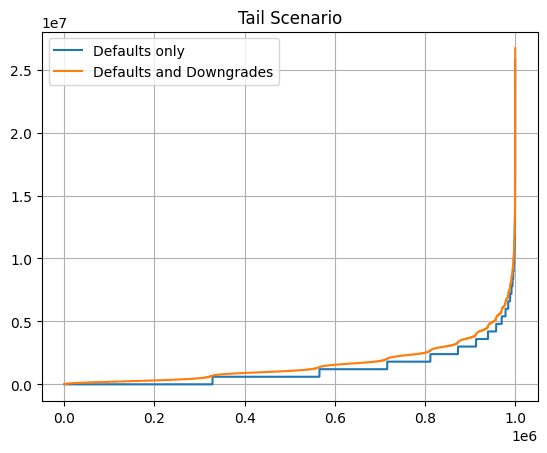

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sorted(scenario_1), label="Defaults only")
plt.plot(sorted(scenario_2), label="Defaults and Downgrades")
plt.legend()
plt.grid()
plt.title("Tail Scenario")

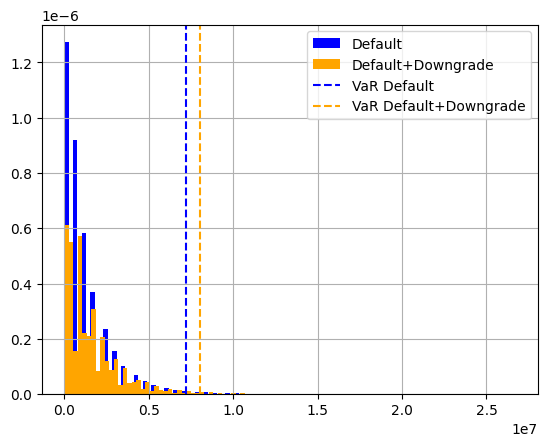

In [88]:
plt.hist(scenario_1, bins=100, density=True, label="Default", color="blue")
plt.hist(scenario_2, bins=100, density=True, label="Default+Downgrade", color="orange")
plt.axvline(var_1, color="blue", linestyle="--", label="VaR Default")
plt.axvline(var_2, color="orange", linestyle="--", label="VaR Default+Downgrade")
plt.legend()
plt.grid()

### 5. Impact of correlation

In the above calculation, we fixed $\rho = 0.15$. Here we change the value in the interval $[0,.3]$, to study how relevant is the impact of this parameter on the asssessment of risk. 

In [89]:
rhos = [0.0, 0.30]
for rho in rhos:
    # Adding correlation
    v_i = np.sqrt(rho)*y + np.sqrt(1-rho)*z

    #Binary variables
    defaults = np.where(v_i < barrier_default, 1, 0)
    downgrades = np.where((barrier_default <= v_i) & (v_i < barrier_downgrade), 1, 0)
    status_quo = np.where(v_i >= barrier_downgrade, 1, 0) 
    upgrades = np.where(v_i > barrier_upgrade, 1, 0)

    scenario, var, el = scenario_sim(defaults_only=False)
    print(f"rho = {rho:.2f} - VaR = {var:,.2f}€    -    Expected loss = {el:,.2f}€")

rho = 0.00 - VaR = 4,014,802.19€    -    Expected loss = 1,633,663.24€
rho = 0.30 - VaR = 12,281,454.65€    -    Expected loss = 1,635,890.45€


As expected, higher correlation between obligors leads to higher risks. To get a more clear view of the situation, we plotted the $VaR$ for each correlation value in between $\rho = 0$ and $\rho = 1$. We observe the relationship is highly non-linear for large values of $\rho$.

Text(0.5, 0, 'Correlation')

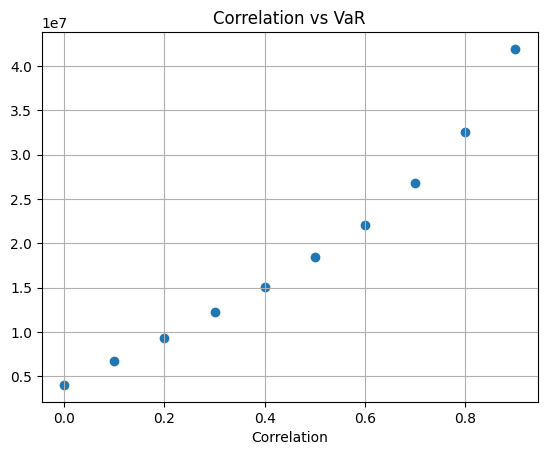

In [90]:
## WARNING: because of the large number of simulations, this cell may take a while to run.
## Estimated time on standard laptop: 10-15 seconds


rhos = np.arange(0.0, 1.0, 0.1)
vars = [None]*len(rhos)
for i,rho in enumerate(rhos):
    # Adding correlation
    v_i = np.sqrt(rho)*y + np.sqrt(1-rho)*z

    #Binary variables
    defaults = np.where(v_i < barrier_default, 1, 0)
    downgrades = np.where((barrier_default <= v_i) & (v_i < barrier_downgrade), 1, 0)
    status_quo = np.where(v_i >= barrier_downgrade, 1, 0) 
    upgrades = np.where(v_i > barrier_upgrade, 1, 0)

    _, vars[i], _ = scenario_sim(defaults_only=False)

plt.scatter(rhos, vars, label="VaR")
plt.grid()
plt.title("Correlation vs VaR")
plt.xlabel("Correlation")

### 7. Recovery rate drops

Lastly, we study the case in which the recovery rate drops to $\pi = 10\%$ in the case of a downgrade. This has a direct impact on the forward $HY$ price, which needs to be recomputed, and will ultimately lead to a higher loss given downgrade. 

In [91]:
# we rerun the initial simulation
rho = 0.15

new_recovery = 0.1

bond_1y2y_def_HY_new = (1-pi_23)*fwd_1y2y + pi_23*fwd_1y1_5y*new_recovery
fwd_price_HY_new = bond_1y2y_def_HY_new*face_value
new_loss_given_down = fwd_price_IG - fwd_price_HY_new

defaults = np.where(v < barrier_default, 1, 0)
downgrades = np.where((barrier_default <= v) & (v < barrier_downgrade), 1, 0)

scenario_new = loss_given_default * np.sum(defaults, axis=1) + new_loss_given_down * np.sum(downgrades, axis=1)

VaR = np.quantile(scenario_new, 0.99)  # 1% VaR
expected_loss = np.mean(scenario_new)  # Expected loss 

print(f"Expected loss: {expected_loss:,.2f}€")
print(f"VaR: {VaR:,.2f}€")

Expected loss: 2,004,149.44€
VaR: 8,705,890.83€
